# Introduction
<img src=https://kr.battle.net/support/static/images/games/tile_wow.d3188b15.jpg width="500">  

월드 오브 워크래프트(World of Warcraft, 이하 WoW)는 블리자드 엔터테인먼트에서 워크래프트 세계관을 바탕으로 최초로 개발한 MMORPG입니다.  
세계 게임 명예의 전당에 최초로 헌액된 여섯 작품 중 하나이고 미국 컴퓨터 역사 박물관이 선택한 '전 세계에 지대한 영향을 끼친 소프트웨어' 7개 중 유일한 게임입니다. 기네스 세계 기록으로 전 세계에서 가장 인기있는 정액제 MMORPG이며, 누적 매출은 115억 달러(2016년 6월)를 넘었습니다.

Source: [World of Warcraft Avatar History Dataset](http://mmnet.iis.sinica.edu.tw/dl/wowah/)  
게임 시스템 디자이너의 관점에서 보면, 플레이어의 행동은 게임 시스템을 설계할 때 반드시 고려해야하는 가장 중요한 요소 중 하나입니다. 온라인 게이머들의 게임 내 행동에 대한 근본적인 이해를 얻기 위해서, 사용자의 게임 플레이 시간을 탐구하는 것은 좋은 출발점이 될 수 있습니다. <b>게임 플레이 시간</b> 개념은 MMORPG 뿐만아니라, 모든 장르의 게임에 적용이 가능하며, 시스템 작업뿐만 아니라 사용자 행덩에 대한 시스템 및 네트워크 QoS의 영향을 모델링할 수 있습니다. 또한 게임에 대한 유저들의 충성심을 예측하는 데 도움을 줄 수 있습니다.  

이 데이터는 91,056개의 캐릭터 기록으로 구성된 WoWAH(World of Warcraft Avatar History)입니다. 데이터의 관측기간은 월드 오브 워크래프트의 오리지날과 '불타는 성전과 리치왕의 분노'확장팩이 출시한 2006년 1월부터 2009년 1월까지 총 1,107일 입니다. 게임 내 캐릭터의 플레이 시간과 종족, 직업, 레벨 및 게임 내 위치와 같은 여러 속성이 제공됩니다.  

로그 추적에 대한 설명
관측기간 동안 모니터링한 91,065개의 캐릭터와 그 캐릭터와 관련된 667,032개의 세션이 관측되었습니다. 샘플링 주기는 10분이었습니다. 플레이어의 프라이버시를 보호하기 위해 캐릭터와 길드 이름은 일관된 매핑(동일한 이름이 항상 동일한 캐릭터로 매핑 됨)으로 이루어졌습니다. 데이터 셋의 요약은 Table 1에 제시되어 있습니다.  

<img src=http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_summary.jpg width="500"> 

캐릭터 로그 파일은 Persistant_Storage 및 RoundInfo의 두 배열로 구성됩니다. 캐릭터 히스토리에 대해 수집 된 모든 데이터는 Persistant_Storage 배열에 저장됩니다. 각 요소는 샘플링 기간 동안 관찰 된 캐릭터에 대한 정보를 저장합니다. 따라서 요소의 수는 샘플링 기간동안 온라인 상태인 캐릭터의 수와 같습니다. 변수의 의미와 그에 대한 범위는 Table 2에 설명되어 있습니다. 또한 Table 3에는 3개의 샘플 행이 존재합니다. 첫 번째 행은 23:59:39에 ID 467인 캐릭터를 관측했음을 나타냅니다. 2006년 1월 1일에 이 캐릭터는 오그리마에 있는 레벨 1 오크 전사였습니다.

<img src=http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_fields.jpg width="500">
<img src=http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_example.jpg width="700">  


# Import Module

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings 
warnings.filterwarnings('ignore')
print(os.listdir('./dataset'))

['locations.csv', 'location_coords.csv', 'wowah_data.csv', 'zones.csv']


# Preparing Dataset

## Define Function

In [2]:
## Function to reduce the DF size
## Source kernel: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
location = pd.read_csv('./dataset/locations.csv', encoding = 'unicode_escape')
location_coord = pd.read_csv('./dataset/location_coords.csv', encoding = 'unicode_escape')
wowah_data = pd.read_csv('./dataset/wowah_data.csv', encoding = 'unicode_escape')
wowah_data = reduce_mem_usage(wowah_data)
zones = pd.read_csv('./dataset/zones.csv', encoding = 'unicode_escape')

Mem. usage decreased to 402.68 Mb (30.4% reduction)


# Location

In [4]:
print('Number of Map_ID:', location.Map_ID.nunique())
print('Number of Location_Type:',location.Location_Type.nunique() )
print('Number of Location_Name:', location.Location_Name.nunique())
print('Number of Game_Version:', location.Game_Version.nunique())
location.head()

Number of Map_ID: 151
Number of Location_Type: 6
Number of Location_Name: 151
Number of Game_Version: 6


,Map_ID,Location_Type,Location_Name,Game_Version
0,0,Continent,Eastern Kingdoms,WoW
1,1,Continent,Kalimdor,WoW
2,530,Continent,Outlands,TBC
3,571,Continent,Northrend,WLK
4,646,Continent,Deepholm,CAT


Map_ID와 Location_Name의 고유값 개수가 같은 것으로 나타났습니다. 따라서 지역 이름별로 고유 ID가 매핑되어 있다는 것을 알 수 있습니다.  
지역 타입(Location_Type)은 다음과 같은 고유값을 가지고 있습니다.
- Continent: 대륙(일반적인 필드)
- Arena: 투기장
- Battleground: 전장
- Garrison: 대도시
- Dungeon: 던전
- Raid: 레이드 던전

게임 버전은 다음과 같은 고유값을 가지고 있습니다.
- WoW: 월드 오브 워크래프트 오리지날 (World of Warcraft)
- TBC: 월드 오브 워크래프트 불타는 성전 (World of Warcraft: The Burning Crusade)
- WLK: 월드 오브 워크래프트 리치왕의 분노 (World of Warcraft: Warth of Lich King)
- CAT: 월드 오브 워크래프트 대격변 (World of Warcraft: Cataclysm)
- MoP: 월드 오브 워크래프트 판다리아의 안개 (World of Warcraft: Mists of Pandaria)
- WoD: 월드 오브 워크래프트 드레노어의 전쟁군주 (World of Warcraft: Warlords of Draenor)

게임 버전을 확인해본 결과, 캐릭터에 대한 관측 기간에 벗어난 확장팩들이 존재한다는 것을 알 수 있습니다.

이제, 각 변수별로 어떤 값들이 가장 많은지 확인합니다. 

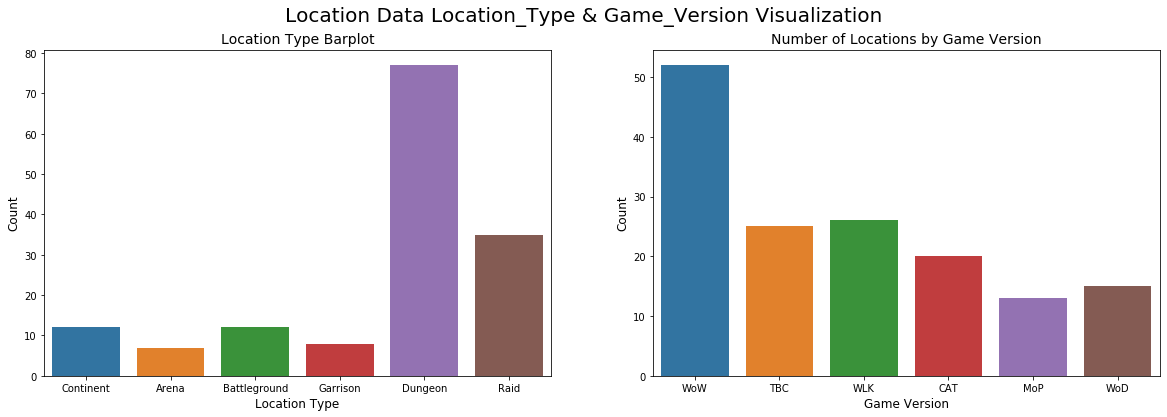

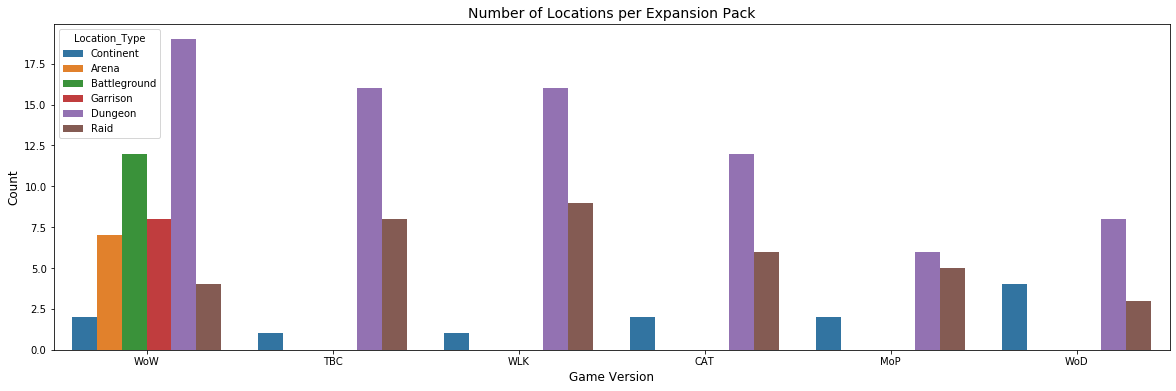

In [5]:
plt.figure(figsize = (20,6))

plt.suptitle('Location Data Location_Type & Game_Version Visualization', fontsize = 20)
plt.subplot(121)
sns.countplot(x = 'Location_Type', data = location)
plt.title('Location Type Barplot', fontsize = 14)
plt.xlabel('Location Type', fontsize =12)
plt.ylabel('Count', fontsize = 12)

plt.subplot(122)
sns.countplot(x = 'Game_Version', data = location)
plt.title('Number of Locations by Game Version', fontsize = 14)
plt.xlabel('Game Version', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.figure(figsize = (20,6))
sns.countplot(hue = 'Location_Type', x = 'Game_Version', data = location)
plt.title('Number of Locations per Expansion Pack', fontsize = 14)
plt.xlabel('Game Version', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

지역 종류(Location_Type)은 던전(Dungeon)이 가장 많았고 그 뒤를 레이드 던전(Raid)이 이었습니다. 이는 매 확장팩마다 던전과 레이드 던전이 가장 많이 추가됐기 때문이라는 것을 확인했습니다.  
월드 오브 워크래프트 오리지날(WoW)에서 가장 많은 지역의 개수가 나타났는데, 이는 투기장(Arena), 전장(Battleground), 대도시(Garrison)이 새롭게 만들어졌기 때문입니다. 나머지 확장팩에서는 데이터 상으로 새롭게 만들어지지 않았습니다.


# wowah_data
캐릭터 정보에 대한 데이터입니다. 컬럼명 가장 앞에 공백이 있기 때문에 컬럼명을 변경합니다.

In [6]:
wowah_data.columns = ['char', 'level','race','charclass', 'zone', 'guild', 'timestamp']

print('Number of Characters:',wowah_data['char'].nunique())
print('Number of levels:', wowah_data['level'].nunique())
print('Number of Races:', wowah_data['race'].nunique())
print('Number of Character Class:', wowah_data['charclass'].nunique())
print('Number of Zones:', wowah_data['zone'].nunique())
print('Number of Guilds:', wowah_data['guild'].nunique())
print('Start Observing Date:', wowah_data['timestamp'].min(),'\n End Observing Date', wowah_data['timestamp'].max())
wowah_data.head()

Number of Characters: 37354
Number of levels: 80
Number of Races: 5
Number of Character Class: 10
Number of Zones: 158
Number of Guilds: 420
Start Observing Date: 01/01/08 00:02:04 
 End Observing Date 12/31/08 23:50:18


,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


관측기간은 2008년 1월 1일부터 2008년 12월 31일까지 1년 데이터로 나타났습니다. 데이터 설명에서 명시했던 2006년 1월부터 2009년 1월이 아닌,  월드 오브 워크래프트: 리치왕의 분노 기간의 데이터입니다.
![](https://w.namu.la/s/fd7c9f2888ba2817322ae2994846c6f73da153519de354f8fa43c1a17cc33bebda6db473fc41506bf5275884db96bc69e24cd74fa8d21ab4ef9ffa5f03fd2523695d78783c4873bd267666c3a37bce103966a4c0f2c8f9cbbf5b98b65899dabc611b02430a48e61d31dfe18f4f8352b0)

관측한 캐릭터의 개수는 총 37,354 개의 캐릭터입니다.

캐릭터의 레벨의 고유값 개수는 80 개로 나타났습니다. 이는, 레벨이 1부터 80까지 다양한 캐릭터의 로그 정보가 남아있음을 알 수 있습니다.

종족은 5 개 종족이며, 2 개의 진영으로 나뉘는 월드 오브 워크래프트의 특성 상, 호드 진영에 속한 캐릭터들의 정보라는 것을 알 수 있습니다. 실제 고유값은 다음과 같습니다
- Orc
- Tauren
- Troll
- Undead
- Blood Elf

직업은 총 10 개이며, 실제 고유값은 다음과 같습니다.
- Rouge
- Hunter
- Warrior
- Shaman
- Warlock
- Druid
- Priest
- Mage
- Paladin
- Death Knight

직업의 뚜렷한 특징은 Paladin은 Blood Elf만 플레이 가능하며, Death Knight는 리치왕의 분노와 함께 출시된 직업입니다.

지역의 개수는 158 개로 Location 데이터에서 확인했던 151 개보다 7개 더 많습니다.

길드의 개수는 420 개이며 -1로 나타난 값은 길드에 속하지 않은 플레이어로 정의합니다.

## 주의사항
- 해당 데이터는 37,354 개의 캐릭터에 대한 Time Stamp 데이터입니다. 따라서 전처리를 하지 않고 탐사 조사를 수행하면 해석의 오류가 발생합니다. 따라서 데이터 정제를 수행한 후, 탐사 조사를 수행합니다. 또한 시간의 흐름에 따라 캐릭터의 레벨은 성장하기 때문에 이를 고려해야 합니다.

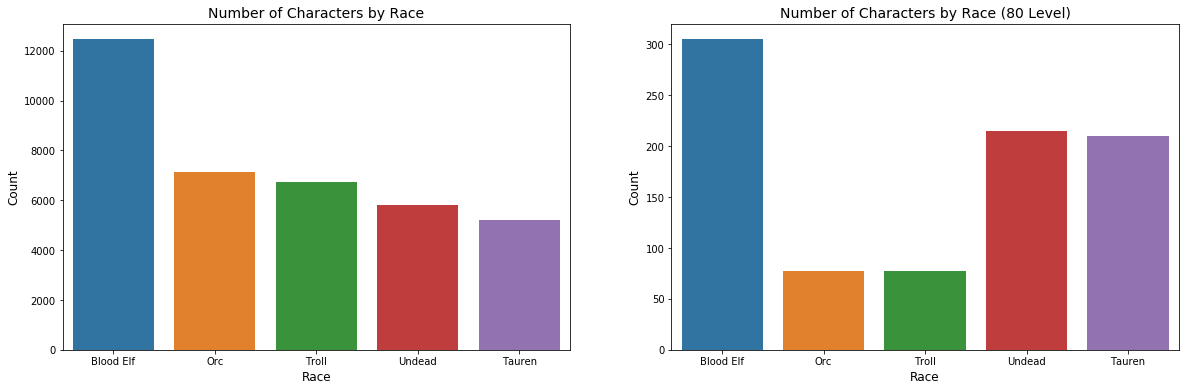

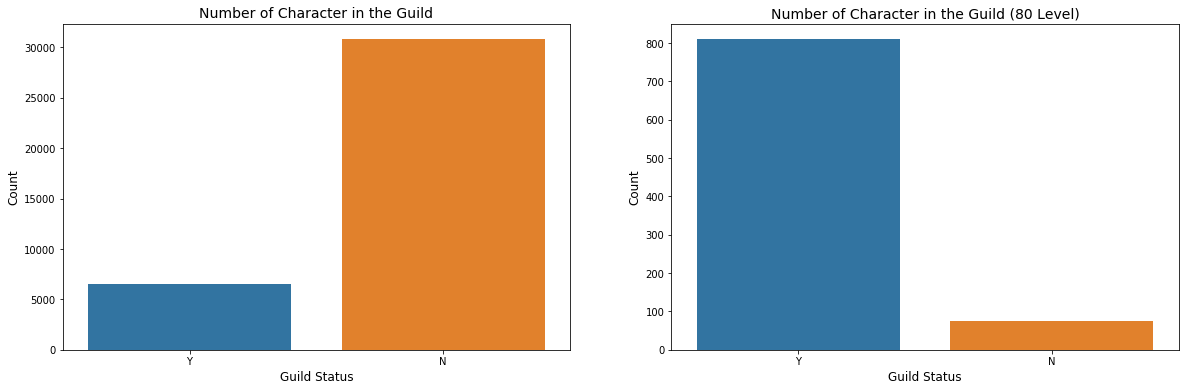

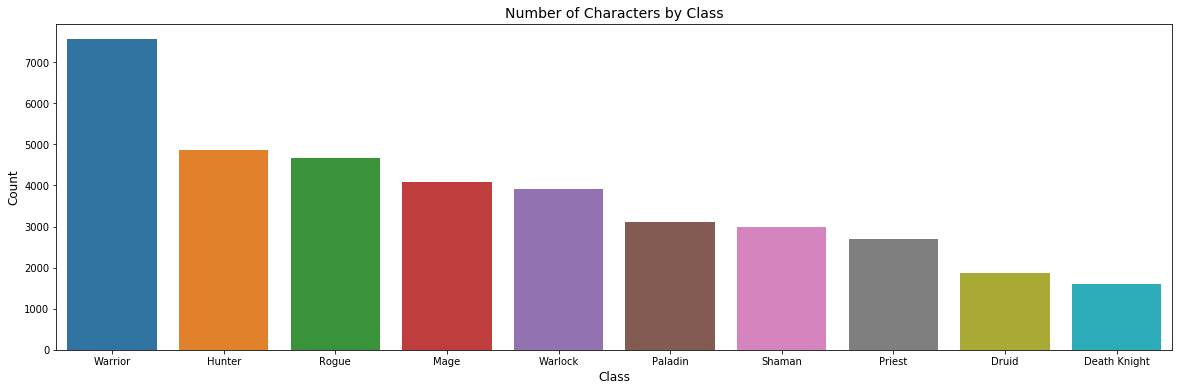

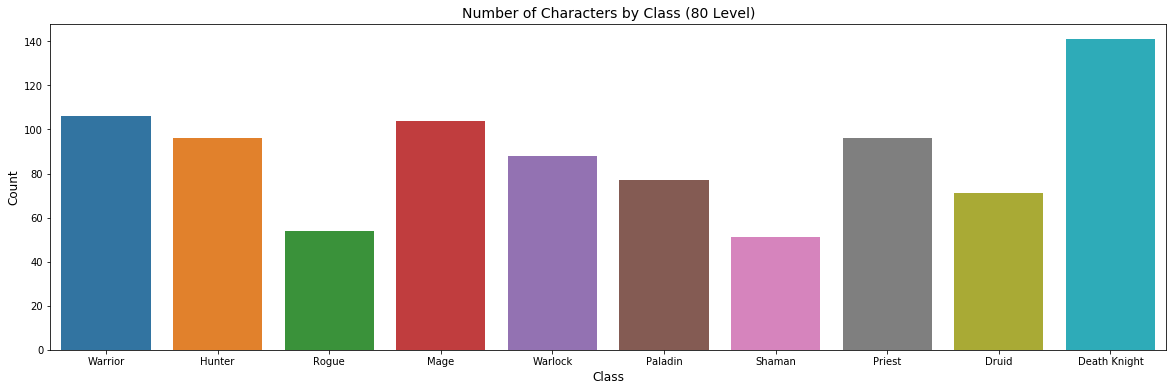

In [42]:
plt.figure(figsize = (20,6))

char_class = wowah_data.drop_duplicates(subset = 'char') # regardless of level
char_class['guild'] = char_class['guild'].apply(lambda x: 'N' if x == -1 else 'Y')

full_level_char_class = wowah_data.loc[wowah_data['level'] == 80].drop_duplicates(subset = 'char')
full_level_char_class['guild'] = full_level_char_class['guild'].apply(lambda x: 'N' if x == -1 else 'Y')

plt.subplot(121)
sns.countplot(char_class['race'], order = char_class['race'].value_counts().index.tolist())
plt.title('Number of Characters by Race', fontsize = 14)
plt.xlabel('Race', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.subplot(122)
sns.countplot(full_level_char_class['race'], order = char_class['race'].value_counts().index.tolist())
plt.title('Number of Characters by Race (80 Level)', fontsize = 14)
plt.xlabel('Race', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.figure(figsize = (20,6))

plt.subplot(121)
sns.countplot(char_class['guild'])
plt.title('Number of Character in the Guild', fontsize = 14)
plt.xlabel('Guild Status', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.subplot(122)
sns.countplot(full_level_char_class['guild'])
plt.title('Number of Character in the Guild (80 Level)', fontsize = 14)
plt.xlabel('Guild Status', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.figure(figsize = (20,6))

sns.countplot(char_class['charclass'], order = char_class['charclass'].value_counts().index.tolist())
plt.title('Number of Characters by Class', fontsize = 14)
plt.xlabel('Class', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.figure(figsize = (20,6))

sns.countplot(full_level_char_class['charclass'], order = char_class['charclass'].value_counts().index.tolist())
plt.title('Number of Characters by Class (80 Level)', fontsize = 14)
plt.xlabel('Class', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

캐릭터 중 가장 많은 종족은 Blood Elf로 나타났습니다. Blood Elf는 월드 오브 워크래프트: 불타는 성전과 함께 출시한 종족임에도 불구하고, 다른 종족에 비해 2 배 가까이 많았습니다.  
80레벨을 달성한 캐릭터 중 가장 많은 종족도 Blood Elf로 나타났습니다. Undead와 Tauren의 비율이 상승했다는 것을 확인 할 수 있습니다. 반면, Orc와 Troll의 비율은 전체 캐릭터 비율보다 낮아졌음을 확인할 수 있습니다.

다음은 MMORPG의 중요 요소 중 하나인 길드에 속한 캐릭터를 확인합니다. 길드에 속하지 않은 캐릭터가 속한 캐릭터보다 6배 가량 많다는 것을 알 수 있습니다.  
그러나 80레벨을 달성한 캐릭터의 대부분은 길드에 가입한 캐릭터라는 것을 알 수 있습니다. 길드의 가입 유무가 만렙 달성에 중요한 요인이라는 것을 알 수 있습니다.

클래스는 Warrior가 뚜렷하게 가장 많은 것으로 나타났습니다. 가장 적은 클래스는 Death Knight로 나타났는데, 가장 최근에 출시한 클래스이기 때문에 개체수가 적은 것으로 판단됩니다.  
반면 80레벨을 달성한 캐릭터 중 가장 많은 클래스는 Death Knight라는 것을 알 수 있습니다. 새로운 직업을 육성하게 되면 만렙에 도달할 가능성이 높다는 가정을 세울 수 있을 것입니다.

그렇다면 종족, 길드 가입 유무, 직업 모두를 고려하여 80 레벨을 달성한 캐릭터는 얼마나 될지 알아보겠습니다.

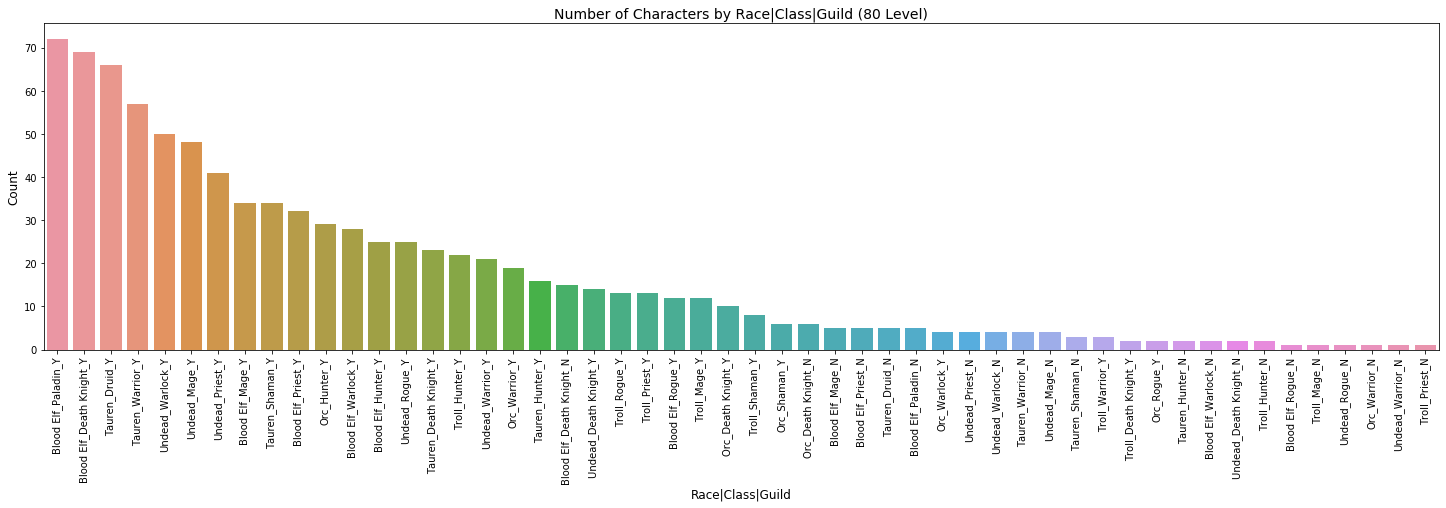

In [57]:
full_level_char_class['three_factor'] = full_level_char_class['race'].astype(str) + "_" + full_level_char_class['charclass'].astype(str) + "_" + full_level_char_class['guild'].astype(str)

plt.figure(figsize = (25,6))
sns.countplot(full_level_char_class['three_factor'], order = full_level_char_class['three_factor'].value_counts().index.tolist())
plt.xticks(rotation = 90)
plt.title('Number of Characters by Race|Class|Guild (80 Level)', fontsize = 14)
plt.xlabel('Race|Class|Guild', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

예상이 가정이 정확하게 맞지는 않았지만, 관측기간 내 길드에 속한 Blood Elf Death Knight가 두 번째로 80레벨을 많이 달성했다는 것을 알 수 있습니다. 가장 80레벨을 많이 달성한 캐릭터 그룹은 길드에 속한 Blood Elf Paladin입니다.